In [1]:
from fastbook import *
from fastai.vision.widgets import *

In [32]:
path = Path('archive')

In [33]:
fns = get_image_files(path)
fns

(#1203) [Path('archive/non_smile/Aaron_Eckhart_0001.jpg'),Path('archive/non_smile/Aaron_Patterson_0001.jpg'),Path('archive/non_smile/Abdel_Nasser_Assidi_0002.jpg'),Path('archive/non_smile/Abdoulaye_Wade_0004.jpg'),Path('archive/non_smile/Abdulaziz_Kamilov_0001.jpg'),Path('archive/non_smile/Abdullah_0003.jpg'),Path('archive/non_smile/Abdullah_Gul_0006.jpg'),Path('archive/non_smile/Abdullatif_Sener_0002.jpg'),Path('archive/non_smile/Abel_Pacheco_0004.jpg'),Path('archive/non_smile/Abid_Hamid_Mahmud_Al-Tikriti_0003.jpg')...]

In [34]:
failed = verify_images(fns)
failed

(#0) []

In [35]:
smile = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

In [36]:
dls = smile.dataloaders(path)

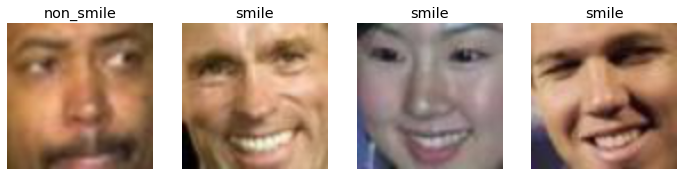

In [37]:
dls.valid.show_batch(max_n=4, nrows=1)

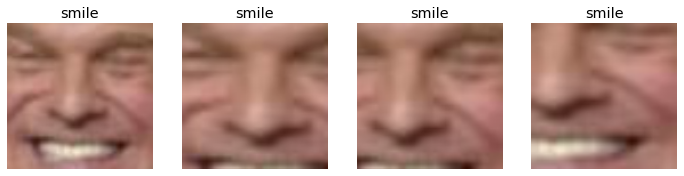

In [38]:
smile = smile.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = smile.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

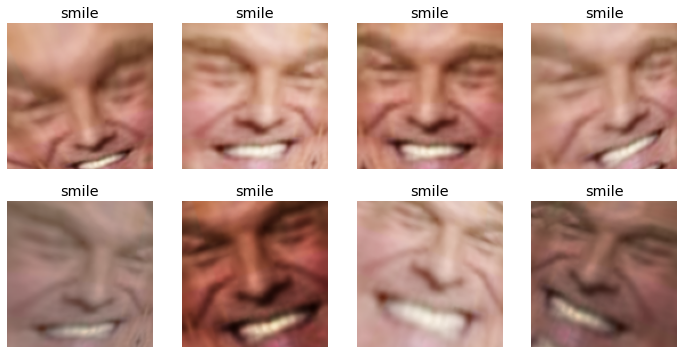

In [39]:
# Data Augmentation
smile = smile.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = smile.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [40]:
smile = smile.new(
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms = aug_transforms()
)
dls = smile.dataloaders(path)

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Alex/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.094451,0.428750,0.158333,01:41


epoch,train_loss,valid_loss,error_rate,time
0,0.656842,0.265770,0.104167,02:11
1,0.554263,0.109672,0.037500,02:11
2,0.455784,0.083008,0.041667,02:11
3,0.404055,0.084179,0.045833,02:10


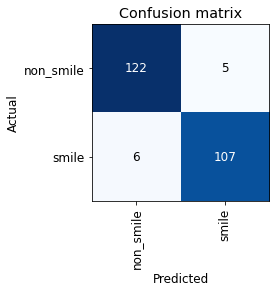

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

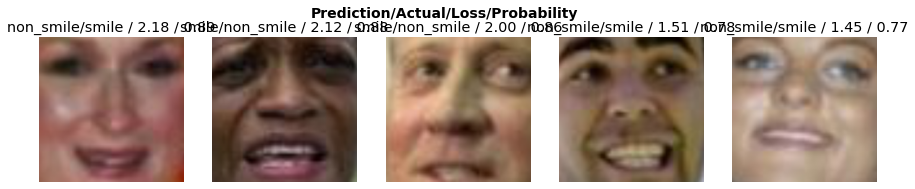

In [27]:
interp.plot_top_losses(5, nrows=1)

In [28]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [30]:
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

In [41]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.954494,0.588488,0.229167,02:57


epoch,train_loss,valid_loss,error_rate,time
0,0.643659,0.318587,0.125000,03:50
1,0.548846,0.229740,0.070833,03:10
2,0.476006,0.153037,0.066667,01:37
3,0.402075,0.134258,0.062500,01:56


In [42]:
learn.export()

In [43]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [44]:
learn_inf = load_learner(path/'export.pkl')

In [45]:
learn_inf.predict('test/Aaron_Guiel_0001.jpg')

('non_smile', TensorBase(0), TensorBase([0.5059, 0.4941]))

In [46]:
learn_inf.dls.vocab

['non_smile', 'smile']

In [47]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [48]:
img = PILImage.create(btn_upload.data[-1])

In [71]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [52]:
pred, pred_idx, probs = learn_inf.predict(img)

In [72]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction:{pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction:smile; Probability: 0.9979')

In [73]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [74]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value=f'Prediction:{pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [75]:
btn_run.on_click(on_click_classify)

In [76]:
VBox([widgets.Label('Upload Face'),
     btn_upload, btn_run, out_pl, lbl_pred])